### This project tries to model the SWMMSE algorithm for Wireless Power Control using Neural Networks, implemented with TensorFlow in Python.

First, let's select TensorFlow version 1.x

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


SWMMSE Algorithm:

In [ ]:
import numpy as np
import math

def SWMMSE(p_int, H, Pmax, var_noise):
    N = np.size(p_int)
    vnew = 0
    v = np.sqrt(p_int)
    u = np.zeros(N)
    w = np.zeros(N)
    a = np.zeros(N)
    b = np.zeros(N)
    VV = np.zeros(100)
    for iter in range(100):
        vold = vnew
        vnew = 0
        for i in range(N):
            u[i] = H[i, i] * v[i] / ((np.square(H[i, :])) @ (np.square(v)) + var_noise)
            w[i] = 1 / (1 - u[i] * v[i] * H[i, i])
            vnew = vnew + math.log2(w[i])
        for i in range(N):
            a[i] = a[i] + sum(w * np.square(u) * np.square(H[:, i]))
            b[i] = b[i] + w[i] * u[i] * H[i, i]
            btmp = b[i]/a[i]
            v[i] = min(btmp, np.sqrt(Pmax)) + max(btmp, 0) - btmp
        VV[iter] = vnew
        if vnew - vold <= 1e-2:
            break
    p_opt = np.square(v)
    return p_opt

Code for Wireless Channel:

In [ ]:
import numpy as np
import time

def channel(N, num_train, Pmax=1, Pmin=0, var_noise=1, seed=1758):
    print('Generate Data ... (seed = %d)' % seed)
    np.random.seed(seed)
    Pini = Pmax * np.ones(N)
    X = np.zeros((N ** 2, num_train))
    Y = np.zeros((num_train, N ))
    X_t = np.zeros((num_train, N, N))
    total_time = 0.0
    for loop in range(num_train):
        CH = 1 / np.sqrt(2) * (np.random.randn(N, N) + 1j * np.random.randn(N, N))
        H = abs(CH)
        X[:, loop] = np.reshape(H, (N ** 2,), order="F")
        H = np.reshape(X[:, loop], (N, N), order="F")
        X_t[loop, :, :] = H
        mid_time = time.time()
        Y[loop, :] = SWMMSE(Pini, H, Pmax, var_noise)
        total_time = total_time + time.time() - mid_time
    return X_t, Y, total_time

Generate Data:

In [ ]:
!mkdir -p /content/data
!pwd
!ls

/content
data  sample_data


In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math

import time

N = 10
num_train = 100000
num_test = 10000
trainseed = 25
testseed = 20

Xtrain, Ytrain, wtime = channel(N, num_train, seed=trainseed)
X, Y, swmmsetime = channel(N, num_test, seed=testseed)

sio.savemat('data/Train_data_%d_%d.mat' %(N, num_train), {'Xtrain': Xtrain, 'Ytrain': Ytrain})
print("Train data Saved")
sio.savemat('data/Test_data_%d_%d.mat' %(N, num_test), {'Xtest': X, 'Ytest': Y, 'swmmsetime': swmmsetime})
print("Test data Saved")

Generate Data ... (seed = 25)
Generate Data ... (seed = 20)
Train data Saved
Test data Saved


Model Training and Testing

In [ ]:
import scipy.io as sio
import numpy as np

import tensorflow as tf
import time

N = 10
num_train = 100000
num_test = 10000
epochs = 100
batch_size = 256
learning_rate = 0.0001

var = 1

load = sio.loadmat('data/Train_data_%d_%d.mat' % (N, num_train))
loadTest = sio.loadmat('data/Test_data_%d_%d.mat' % (N, num_test))
Htrain = load['Xtrain']
Ptrain = load['Ytrain']
H_test = loadTest['Xtest']
P_test = loadTest['Ytest']
timeW = loadTest['swmmsetime']

weights = {
    'w_1': tf.Variable(tf.random_normal([N*N, 100], stddev=0.1)),
    'w_2': tf.Variable(tf.random_normal([100, 100], stddev=0.1)),
    'w_3': tf.Variable(tf.random_normal([100, 100], stddev=0.1)),
    'w_out': tf.Variable(tf.random_normal([100, N])),
}

biases = {

    'b_1': tf.Variable(tf.random_normal([100], stddev=0.1)),
    'b_2': tf.Variable(tf.random_normal([100], stddev=0.1)),
    'b_3': tf.Variable(tf.random_normal([100], stddev=0.1)),
    'b_out': tf.Variable(tf.random_normal([N])),
}

def network(input_data):
    h_layer_1 = tf.add(tf.matmul(input_data, weights['w_1']), biases['b_1'])  #h1 = wx+b
    h_layer_1 = tf.nn.relu(h_layer_1)

    h_layer_2 = tf.add(tf.matmul(h_layer_1, weights['w_2']), biases['b_1'])
    h_layer_2 = tf.nn.relu(h_layer_2)

    h_layer_3 = tf.add(tf.matmul(h_layer_2, weights['w_3']), biases['b_3'])
    h_layer_3 = tf.nn.relu(h_layer_3)

    output = tf.matmul(h_layer_3, weights['w_out']) + biases['b_out']
    output = tf.nn.relu6(output) / 6

    return output

valid_split = 0.1

total_sample_size = num_train
validation_sample_size = int(total_sample_size*valid_split)
training_sample_size = total_sample_size - validation_sample_size

Htrain = np.reshape(Htrain, (total_sample_size, N*N))
number_input = N*N
number_output = N

H_train = Htrain[ 0:training_sample_size, :]
P_train = Ptrain[0:training_sample_size, :]
H_val = Htrain[training_sample_size:total_sample_size, :]
P_val = Ptrain[training_sample_size:total_sample_size, :]

x = tf.placeholder(tf.float32, [None, N*N])
y = tf.placeholder(tf.float32, [None, N])

total_batch = int(total_sample_size / batch_size)

x_bar = network(x)
loss = tf.reduce_mean(tf.square(x_bar - y))

optimizer = tf.train.AdamOptimizer(learning_rate)
objective = optimizer.minimize(loss)

save_data = np.zeros((epochs, 3))

session = tf.InteractiveSession()
tf.global_variables_initializer().run()

start_time = time.time()
for e in range(epochs):
    for b in range(total_batch):
        batch = np.random.randint(training_sample_size, size=batch_size)
        _, training_cost = session.run([objective, loss], feed_dict={x: H_train[batch, :], y: P_train[batch, :]})
        save_data[e, 0] = training_cost
    validation_cost = session.run(loss, feed_dict={x: H_val, y: P_val})
    save_data[e, 1] = validation_cost
    save_data[e, 2] = e
    if (e % 2 == 0):
        print('\n %d ' % e, ' %f ' % (training_cost), ' %f ' % (validation_cost), ' %f ' % (time.time() - start_time), )
    else:
        print("#", end="")
print("training time: %0.2f s" % (time.time() - start_time))
sio.savemat('MSETime_%d_%d_%d' % (N, batch_size, learning_rate * 10000), {'train': save_data[:, 0], 'validation': save_data[:, 1], 'epoch': save_data[:, 2]})

start_time = time.time()
H_test_r = np.reshape(H_test, (num_test, N*N))
predicted_power = session.run(x_bar, feed_dict={x: H_test_r, y: P_test})
pred_time = time.time()-start_time
print(predicted_power.shape)
predicted_power = np.reshape(predicted_power,(num_test,N))

def IC_sum_rate(H, p, var_noise):
    H = np.square(H)
    fr = np.diag(H)*p
    ag = np.dot(H,p) + var_noise - fr
    y = np.sum(np.log(1+fr/ag) )
    return y
def np_sum_rate(X,Y):
    avg = 0
    n = X.shape[0]
    for i in range(n):
        avg += IC_sum_rate(X[i,:,:],Y[i,:],1)/n
    return avg

sum_rate_dnn = np_sum_rate(H_test,predicted_power)*np.log2(np.exp(1))
sum_rate_swmmse = np_sum_rate(H_test,P_test)*np.log2(np.exp(1))

print('Average rate for DNN', sum_rate_dnn, "bits per second")
print('Average rate for SWMMSE', sum_rate_swmmse, "bits per second")
print("%f%% in %f sec time" % (sum_rate_dnn/sum_rate_swmmse*100, pred_time))


 0   0.178034   0.183518   1.547204 
#
 2   0.107226   0.109330   4.478600 
#
 4   0.107052   0.100390   7.373577 
#
 6   0.104224   0.098696   10.249271 
#
 8   0.093052   0.097684   13.090625 
#
 10   0.096959   0.096959   15.985299 
#
 12   0.096432   0.097267   18.848364 
#
 14   0.099664   0.097527   21.781546 
#
 16   0.093456   0.096988   24.641989 
#
 18   0.096282   0.096453   27.496976 
#
 20   0.096758   0.096663   30.460558 
#
 22   0.092054   0.096438   33.385869 
#
 24   0.094420   0.096132   36.309299 
#
 26   0.102367   0.096343   39.193704 
#
 28   0.093838   0.095906   42.029695 
#
 30   0.099828   0.096139   44.898895 
#
 32   0.092368   0.096612   47.774128 
#
 34   0.099010   0.095582   50.648354 
#
 36   0.084688   0.095818   53.525236 
#
 38   0.090047   0.095158   56.429724 
#
 40   0.092198   0.095871   59.346645 
#
 42   0.096812   0.095110   62.208328 
#
 44   0.091742   0.094901   65.080937 
#
 46   0.095421   0.094752   67.929825 
#
 48   0.095630   0.0945

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt

PlotData = sio.loadmat("/content/MSETime_10_256_1")

epochs = PlotData['epoch'][0]
train = PlotData['train'][0]
vald = PlotData['validation'][0]

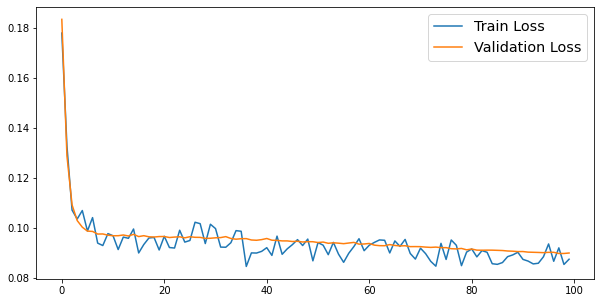

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train, label = "Train Loss")
plt.plot(vald, label = "Validation Loss")
plt.legend(fontsize="x-large")
plt.show()

This notebook contains the implementations of the following paper:

M. H. Rahman and M. M. Mowla, "**[A Deep Neural Network Based Optimization Approach for Wireless Resource Management](https://ieeexplore.ieee.org/document/9230822),**" 2020 IEEE Region 10 Symposium (TENSYMP), Dhaka, Bangladesh, 2020, pp. 803-806, doi: 10.1109/TENSYMP50017.2020.9230822

The work was done by <br>
[**Next Generation Wireless Communication Lab**](https://sites.google.com/view/ruetete-ngwc/) <br>
**Department of Electronics & Telecommunication Engineering (ETE)** <br>
**Rajshahi University of Engineering & Technology (RUET)**

**Shahriar Shanto** is a Research Student at this lab.